# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

# Package to filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data Loading and other standard packages
import sqlite3
import nltk
import string
import re
import pickle
import os
import time
import string
import pickle
import pandas as pd
import numpy as np
from scipy import interp
from tqdm import tqdm
from scipy.sparse import find
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import coo_matrix, vstack, hstack


# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus

# Preprocessing packages
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

# Packages related to text processing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn import decomposition
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Packages for performance metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# Packages for crossvalidation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

# Model packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


C:\Users\soura\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

## Time based splitting
* Sort the data based on `Time` column
* Get the 80% data for train and 20% data on test

In [22]:
# time based splitting for a dataframe
def split_time_based(df, time_col, train_perc):
    if type(df).__name__ != 'DataFrame':
        print("Please provide a dataframe!")
    if type(time_col).__name__ != 'list':
        print("Please porvide the time column as list")
    # Sort the dataframe based on time column
    df.sort_values(by=time_col, inplace=True)
    df_row, df_col = df.shape
    train_row = round(df_row * (train_perc/100))
    test_row = df_row - train_row
    return df.head(train_row), df.tail(test_row)

In [23]:
# Splitting the data based on Time column, where train=80% and test=20%
final_train, final_test = split_time_based(final, ['Time'], 80)
print(final_train.shape)
print(final_test.shape)

(70218, 10)
(17555, 10)


In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_train = []
# tqdm is for printing the status bar
for sentance in tqdm(final_train['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_train.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 70218/70218 [00:20<00:00, 3379.34it/s]


In [25]:
# Combining all the above stundents for another feature to include feature engineering 
from tqdm import tqdm
preprocessed_reviews_train_f = []
# tqdm is for printing the status bar
for sentance in tqdm(final_train['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_train_f.append(sentance.strip())

  3%|█▉                                                                         | 1832/70218 [00:00<00:15, 4554.48it/s]C:\Users\soura\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 54%|███████████████████████████████████████▋                                  | 37673/70218 [00:07<00:06, 5193.81it/s]C:\Users\soura\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 69%|███████████████████████████████████████████████████▍                      | 48791/70218 [00:09<00:04, 5217.64it/s]C:\Users\soura\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_test = []
# tqdm is for printing the status bar
for sentance in tqdm(final_test['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_test.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 17555/17555 [00:05<00:00, 3438.55it/s]


In [27]:
# Combining all the above stundents for another feature to include feature engineering
from tqdm import tqdm
preprocessed_reviews_test_f = []
# tqdm is for printing the status bar
for sentance in tqdm(final_test['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_test_f.append(sentance.strip())

 13%|█████████▊                                                                 | 2311/17555 [00:00<00:03, 4527.80it/s]C:\Users\soura\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████████████████████████████████████████████████████████████████████| 17555/17555 [00:03<00:00, 5034.89it/s]


In [28]:
print("Train: ",len(preprocessed_reviews_train))
print("Test: ",len(preprocessed_reviews_test))

Train:  70218
Test:  17555


In [29]:
print("Train: ",len(preprocessed_reviews_train_f))
print("Test: ",len(preprocessed_reviews_test_f))

Train:  70218
Test:  17555


In [30]:
y_train = final_train['Score']
y_test = final_test['Score']

y_train = y_train.values
y_test = y_test.values

# [4] Featurization

## [4.1] BAG OF WORDS

In [31]:
def bag_of_words_fit(data, min_df,max_features):
    count_vect = CountVectorizer(min_df=min_df, max_features=max_features)
    count_vect.fit(data)
    print("some feature names ", count_vect.get_feature_names()[:10])
    print('='*50)
    
    return count_vect
    
def bag_of_words_transform(vectorizer, data):
    final_counts = vectorizer.transform(data)
    print("the type of count vectorizer ",type(final_counts))
    print("the shape of out text BOW vectorizer ",final_counts.get_shape())
    print("the number of unique words ", final_counts.get_shape()[1])
    
    return final_counts

## [4.2] TF-IDF

In [32]:
def tf_idf_vector_fit(data, ngram, min_df, max_features):
    tf_idf_vect = TfidfVectorizer(ngram_range=ngram, min_df=min_df, max_features=max_features)
    tf_idf_vect.fit(data)
    print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
    print('='*50)
    
    return tf_idf_vect
    
def tf_idf_vector_transform(vectorizer, data):
    final_tf_idf = vectorizer.transform(data)
    print("the type of count vectorizer ",type(final_tf_idf))
    print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
    
    return final_tf_idf

## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [33]:
def avg_w2vec_model(corpus, min_count, size, workers):
    i=0
    list_of_sentance=[]
    for sentance in corpus:
        list_of_sentance.append(sentance.split())

    # Applying to W2V model on text corpus
    w2v_model=Word2Vec(list_of_sentance,min_count=min_count,size=size, workers=workers)
    w2v_words = list(w2v_model.wv.vocab)

    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(size) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    
    return sent_vectors

#### [4.3.1.2] TFIDF weighted W2v

In [34]:
def tfidf_w2vec_model(corpus, min_count, size, workers):
    list_of_sentance=[]
    for sentance in corpus:
        list_of_sentance.append(sentance.split())

    # Applying to W2V model on text corpus
    w2v_model=Word2Vec(list_of_sentance,min_count=min_count,size=size, workers=workers)
    w2v_words = list(w2v_model.wv.vocab)
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(corpus)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec for Train data
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(size) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    return tfidf_sent_vectors

## Getting the vectorized data

In [35]:
print(50*'*','BOW TRAIN',50*'*')
vectorizer = bag_of_words_fit(preprocessed_reviews_train, 5, None)
with open('bow_vectorizer.pkl', 'wb') as obj:
    pickle.dump(vectorizer, obj)
bow_train = bag_of_words_transform(vectorizer, preprocessed_reviews_train)
print(50*'*','BOW TEST',50*'*')
bow_test = bag_of_words_transform(vectorizer, preprocessed_reviews_test)

print(50*'*','TFIDF TRAIN',50*'*')
vectorizer = tf_idf_vector_fit(preprocessed_reviews_train, (1,2), 5, None)
with open('tfidf_vectorizer.pkl', 'wb') as obj:
    pickle.dump(vectorizer, obj)
tfidf_train = tf_idf_vector_transform(vectorizer, preprocessed_reviews_train)
print(50*'*','TFIDF TEST',50*'*')
tfidf_test = tf_idf_vector_transform(vectorizer, preprocessed_reviews_test)

print(50*'*','AVG W2VEC TRAIN',50*'*')
avg_w2vec_train = avg_w2vec_model(preprocessed_reviews_train, 10, 500, 4)
print(50*'*','AVG W2VEC TEST',50*'*')
avg_w2vec_test = avg_w2vec_model(preprocessed_reviews_test, 10, 500, 4)

print(50*'*','TFIDF W2VEC TRAIN',50*'*')
tfidf_w2vec_train = tfidf_w2vec_model(preprocessed_reviews_train, 10, 500, 4)
print(50*'*','TFIDF W2VEC TEST',50*'*')
tfidf_w2vec_test = tfidf_w2vec_model(preprocessed_reviews_test, 10, 500, 4)

************************************************** BOW TRAIN **************************************************
some feature names  ['aa', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abide']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70218, 14970)
the number of unique words  14970
************************************************** BOW TEST **************************************************
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 14970)
the number of unique words  14970
************************************************** TFIDF TRAIN **************************************************
some sample features(unique words in the corpus) ['aa', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal pain']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out 

100%|███████████████████████████████████████████████████████████████████████████| 70218/70218 [01:16<00:00, 914.12it/s]


70218
500
************************************************** AVG W2VEC TEST **************************************************


100%|██████████████████████████████████████████████████████████████████████████| 17555/17555 [00:14<00:00, 1213.68it/s]


17555
500
************************************************** TFIDF W2VEC TRAIN **************************************************


100%|████████████████████████████████████████████████████████████████████████████| 70218/70218 [16:09<00:00, 72.41it/s]


************************************************** TFIDF W2VEC TEST **************************************************


100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [02:08<00:00, 136.77it/s]


In [36]:
print(50*'*','BOW TRAIN',50*'*')
vectorizer = bag_of_words_fit(preprocessed_reviews_train_f, 5, None)
with open('bow_vectorizer_f.pkl', 'wb') as obj:
    pickle.dump(vectorizer, obj)
bow_train_f = bag_of_words_transform(vectorizer, preprocessed_reviews_train_f)
print(50*'*','BOW TEST',50*'*')
bow_test_f = bag_of_words_transform(vectorizer, preprocessed_reviews_test_f)

print(50*'*','TFIDF TRAIN',50*'*')
vectorizer = tf_idf_vector_fit(preprocessed_reviews_train_f, (1,2), 5, None)
with open('tfidf_vectorizer_f.pkl', 'wb') as obj:
    pickle.dump(vectorizer, obj)
tfidf_train_f = tf_idf_vector_transform(vectorizer, preprocessed_reviews_train_f)
print(50*'*','TFIDF TEST',50*'*')
tfidf_test_f = tf_idf_vector_transform(vectorizer, preprocessed_reviews_test_f)

print(50*'*','AVG W2VEC TRAIN',50*'*')
avg_w2vec_train_f = avg_w2vec_model(preprocessed_reviews_train_f, 10, 500, 4)
print(50*'*','AVG W2VEC TEST',50*'*')
avg_w2vec_test_f = avg_w2vec_model(preprocessed_reviews_test_f, 10, 500, 4)

print(50*'*','TFIDF W2VEC TRAIN',50*'*')
tfidf_w2vec_train_f = tfidf_w2vec_model(preprocessed_reviews_train_f, 10, 500, 4)
print(50*'*','TFIDF W2VEC TEST',50*'*')
tfidf_w2vec_test_f = tfidf_w2vec_model(preprocessed_reviews_test_f, 10, 500, 4)

************************************************** BOW TRAIN **************************************************
some feature names  ['aa', 'able', 'absolute', 'absolutely', 'acai', 'acceptable', 'according', 'accurate', 'acid', 'acidic']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70218, 3512)
the number of unique words  3512
************************************************** BOW TEST **************************************************
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 3512)
the number of unique words  3512
************************************************** TFIDF TRAIN **************************************************
some sample features(unique words in the corpus) ['aa', 'able', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely amazing', 'absolutely best', 'absolutely delicious', 'absolutely disgusting']
the type of c

100%|█████████████████████████████████████████████████████████████████████████| 70218/70218 [00:03<00:00, 21842.49it/s]


70218
500
************************************************** AVG W2VEC TEST **************************************************


100%|█████████████████████████████████████████████████████████████████████████| 17555/17555 [00:00<00:00, 37173.30it/s]


17555
500
************************************************** TFIDF W2VEC TRAIN **************************************************


100%|██████████████████████████████████████████████████████████████████████████| 70218/70218 [00:19<00:00, 3629.47it/s]


************************************************** TFIDF W2VEC TEST **************************************************


100%|██████████████████████████████████████████████████████████████████████████| 17555/17555 [00:02<00:00, 8018.25it/s]


## Pickle/Unpickle data Function

In [2]:
def pickle_data(file_name, data_object):
    f_obj = open(file_name,'wb')
    pickle.dump(data_object, f_obj)
    f_obj.close()

def unpickle_data(file_name):
    f_obj = open(file_name,'rb')
    data_object = pickle.load(f_obj)
    f_obj.close()
    
    return data_object

In [38]:
file_names = ['bow_train.pkl', 'bow_test.pkl', 'tfidf_train.pkl', 'tfidf_test.pkl', 'avg_w2vec_train.pkl', 'avg_w2vec_test.pkl',
              'tfidf_w2vec_train.pkl', 'tfidf_w2vec_test.pkl', 'y_train.pkl', 'y_test.pkl']
data_objects = [bow_train, bow_test, tfidf_train, tfidf_test, avg_w2vec_train, avg_w2vec_test,
              tfidf_w2vec_train, tfidf_w2vec_test, y_train, y_test]

for i in zip(file_names, data_objects):
    pickle_data(i[0], i[1])

In [39]:
file_names = ['bow_train_f.pkl', 'bow_test_f.pkl', 'tfidf_train_f.pkl', 'tfidf_test_f.pkl', 'avg_w2vec_train_f.pkl', 'avg_w2vec_test_f.pkl',
              'tfidf_w2vec_train_f.pkl', 'tfidf_w2vec_test_f.pkl']
data_objects = [bow_train_f, bow_test_f, tfidf_train_f, tfidf_test_f, avg_w2vec_train_f, avg_w2vec_test_f,
              tfidf_w2vec_train_f, tfidf_w2vec_test_f]

for i in zip(file_names, data_objects):
    pickle_data(i[0], i[1])

## Defining Functions

In [3]:
#defining function to apply Randon Forest Classifier
def apply_random_forest(x_train, y_train, estimators, depth_vals, cross_val_number):    
    # define Randon Forest to use in crossvalidation
    parameter = {'n_estimators':estimators, 'max_depth':depth_vals} # Define hyper parameters
    rfc = RandomForestClassifier()
    clf = GridSearchCV(rfc, parameter, cv=cross_val_number, scoring='roc_auc', n_jobs=3, verbose=1) #Use GridSearchCV for hyper parameter tuning
    clf.fit(x_train, y_train)
    return clf

In [4]:
#defining function to apply GBDT Classifier using xgboost
def apply_xgboost(x_train, y_train, estimators, depth_vals, cross_val_number):    
    # define XGBoost to use in crossvalidation
    parameter = {'n_estimators':estimators, 'max_depth':depth_vals} # Define hyper parameters
    xgb = XGBClassifier()
    clf = GridSearchCV(xgb, parameter, cv=cross_val_number, scoring='roc_auc', n_jobs=3, verbose=1) #Use GridSearchCV for hyper parameter tuning
    clf.fit(x_train, y_train)
    return clf

In [5]:
#defining function to apply GBDT Classifier using xgboost for W2Vec
def apply_xgboost1(x_train, y_train, estimators, depth_vals, cross_val_number):    
    # define XGBoost to use in crossvalidation
    parameter = {'n_estimators':estimators, 'max_depth':depth_vals} # Define hyper parameters
    xgb = XGBClassifier(colsample_bytree=0.5)
    clf = GridSearchCV(xgb, parameter, cv=cross_val_number, scoring='roc_auc', n_jobs=3, verbose=1) #Use GridSearchCV for hyper parameter tuning
    clf.fit(x_train, y_train)
    return clf

In [6]:
# Define Function to plot AUC vs alpha curve
def plot_auc_vs_hyperparam_curve(xaxis1, yaxis1, xaxis2, yaxis2, title, xlab, ylab):
    plt.title(title)
    plt.plot(xaxis1, yaxis1)
    plt.plot(xaxis2, yaxis2)
    plt.legend(('Train', 'Test'))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [7]:
# Define function to Plot the ROC curve
def plot_roc_curve_for_test(fpr, tpr,fpr_train, tpr_train, title):
    plt.title(title)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
    plt.plot(fpr, tpr, color='b')
    plt.plot(fpr_train, tpr_train, color='g')
    plt.legend(('No Prediction', 'Test', 'Train'))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [8]:
# Define function to standardize data
def perform_standardization(x_train, x_test):
    if (type(x_train).__name__ == 'csr_matrix') and (type(x_test).__name__ == 'csr_matrix'):
        scaler = MaxAbsScaler().fit(x_train)
        x_train_std = scaler.transform(x_train)
        x_test_std = scaler.transform(x_test)
        return x_train_std, x_test_std
    elif (type(x_train).__name__ == 'coo_matrix') and (type(x_test).__name__ == 'coo_matrix'):
        scaler = MaxAbsScaler().fit(x_train)
        x_train_std = scaler.transform(x_train)
        x_test_std = scaler.transform(x_test)
        return x_train_std, x_test_std
    else:
        scaler = StandardScaler().fit(x_train)
        x_train_std = scaler.transform(x_train)
        x_test_std = scaler.transform(x_test)
        return x_train_std, x_test_std

In [9]:
# Define function for word cloud
def create_word_cloud(data,font_sz, fig_size):
    plt.figure(figsize=fig_size)

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
            background_color='white',
            stopwords=stopwords,
            max_words=200,
            max_font_size=font_sz, 
            scale=3,
            random_state=1
        ).generate(str(data))
    plt.imshow(wordcloud)
    plt.show()

In [10]:
estimators_rf = [40,60,80,100,120]
estimators_xgb = [200,300,400,500,600]
max_depth_of_tree_rf = [100,200,300,500,800,1000] # Deep trees for RF models
max_depth_of_tree_xgb = [1,3,5,7,9,11] # Shallow trees for GBDT models
estimators_xgb1 = [10, 50, 100, 200, 500]
max_depth_of_tree_xgb1 = [1,3,5,7,9,11]

# Applying Random Forest

## [5.1] Applying Random Forest on BOW,<font color='red'> SET 1</font>

In [58]:
%time
# Unpickle BoW Data
x_train = unpickle_data('bow_train.pkl')
y_train = unpickle_data('y_train.pkl')
bow_clf_rf = apply_random_forest(x_train, y_train, estimators_rf, max_depth_of_tree_rf, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 13.5min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 64.9min finished


In [59]:
# pickling the classifier object
pickle_data('bow_clf_rf.pkl',bow_clf_rf)

In [60]:
print("Optimal Parameters: {}".format(bow_clf_rf.best_params_))
print("Best AUC Score is: {}".format(bow_clf_rf.best_score_))

Optimal Parameters: {'max_depth': 1000, 'n_estimators': 120}
Best AUC Score is: 0.9106723949625368


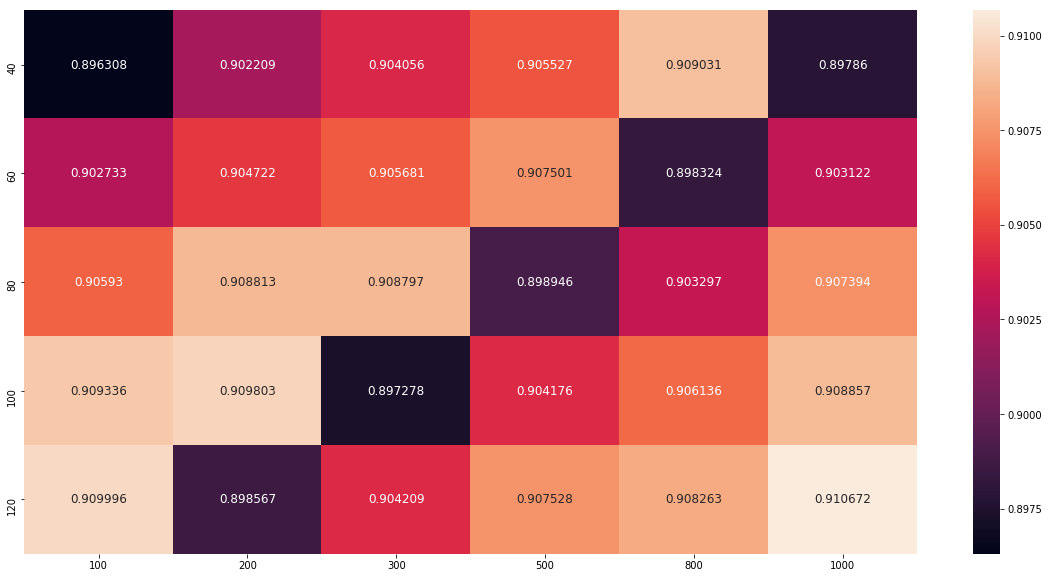

In [61]:
accuracy=bow_clf_rf.cv_results_['mean_test_score'].reshape(len(estimators_rf),len(max_depth_of_tree_rf))
df=pd.DataFrame(accuracy, index=estimators_rf, columns=max_depth_of_tree_rf)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

Accuracy on test set: 87.707%
Precision on test set: 0.874
Recall on test set: 0.996
F1-Score on test set: 0.931



Confusion Matrix of test set


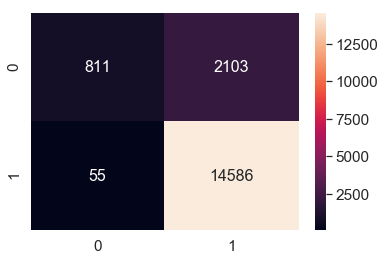

In [63]:
# Apply Decision Tree on Test data
x_test = unpickle_data('bow_test.pkl')
y_test = unpickle_data('y_test.pkl')
rf_optimal = RandomForestClassifier(max_depth=bow_clf_rf.best_params_['max_depth'],n_estimators=bow_clf_rf.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
proba = rf_optimal.predict_proba(x_test)
proba_train = rf_optimal.predict_proba(x_train)
pred = rf_optimal.predict(x_test)
pred_train = rf_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion Matrix of train set


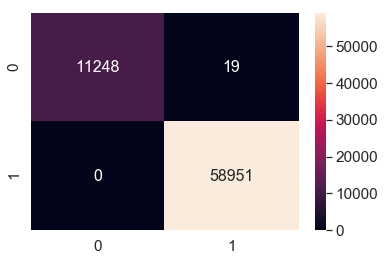

In [64]:
print("Confusion Matrix of train set")
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

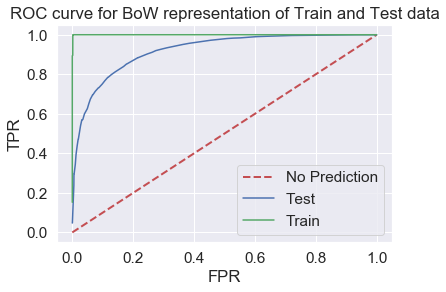

In [65]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr, fpr_train, tpr_train, 'ROC curve for BoW representation of Train and Test data')

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [75]:
# get the BoW feature names
bow_features=unpickle_data('bow_vectorizer.pkl').get_feature_names()

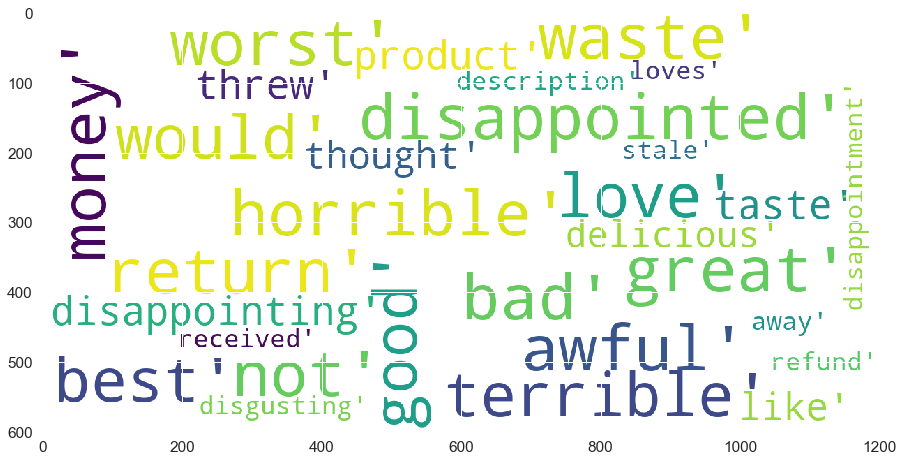

In [76]:
create_word_cloud(np.array(bow_features)[np.argsort(rf_optimal.feature_importances_)[::-1][:30]],30,(15,8))

## [5.2] Applying Random Forest on TFIDF,<font color='red'> SET 2</font>

In [67]:
%time
# Unpickle BoW Data
x_train = unpickle_data('tfidf_train.pkl')
y_train = unpickle_data('y_train.pkl')
tfidf_clf_rf = apply_random_forest(x_train, y_train, estimators_rf, max_depth_of_tree_rf, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 18.8min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 97.1min finished


In [68]:
# Pickling the tfidf classifier
pickle_data('tfidf_clf_rf.pkl', tfidf_clf_rf)

In [69]:
print("Optimal Parameters: {}".format(tfidf_clf_rf.best_params_))
print("Best AUC Score is: {}".format(tfidf_clf_rf.best_score_))

Optimal Parameters: {'max_depth': 800, 'n_estimators': 120}
Best AUC Score is: 0.9333660829948764


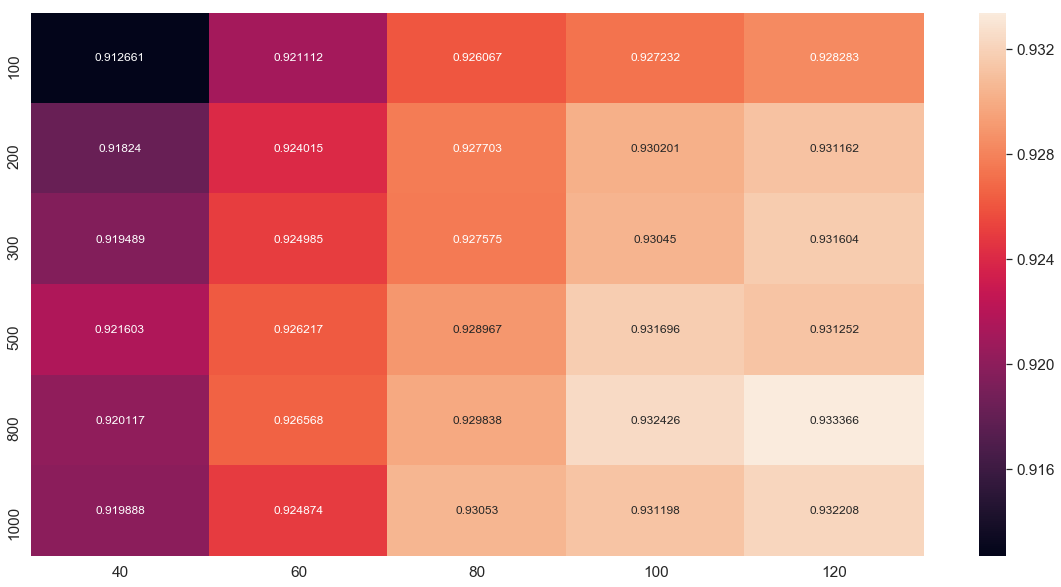

In [74]:
accuracy=tfidf_clf_rf.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_rf),len(estimators_rf))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_rf, columns=estimators_rf)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

Accuracy on test set: 87.479%
Precision on test set: 0.871
Recall on test set: 0.998
F1-Score on test set: 0.930



Confusion Matrix of test set


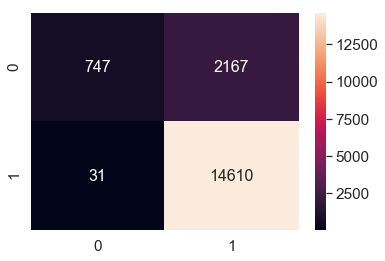

In [78]:
# Apply Random Forest on Test data
x_test = unpickle_data('tfidf_test.pkl')
y_test = unpickle_data('y_test.pkl')
rf_optimal = RandomForestClassifier(max_depth=tfidf_clf_rf.best_params_['max_depth'],n_estimators=tfidf_clf_rf.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
proba = rf_optimal.predict_proba(x_test)
proba_train = rf_optimal.predict_proba(x_train)
pred = rf_optimal.predict(x_test)
pred_train = rf_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion Matrix of train set


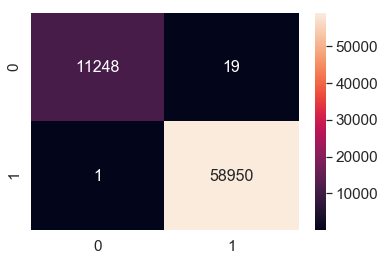

In [79]:
print("Confusion Matrix of train set")
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

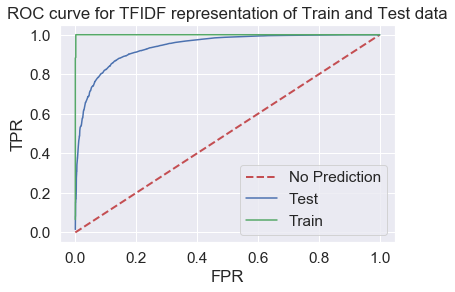

In [80]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr,fpr_train,tpr_train, 'ROC curve for TFIDF representation of Train and Test data')

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [81]:
# get the TFIDF feature names
tfidf_features=unpickle_data('tfidf_vectorizer.pkl').get_feature_names()

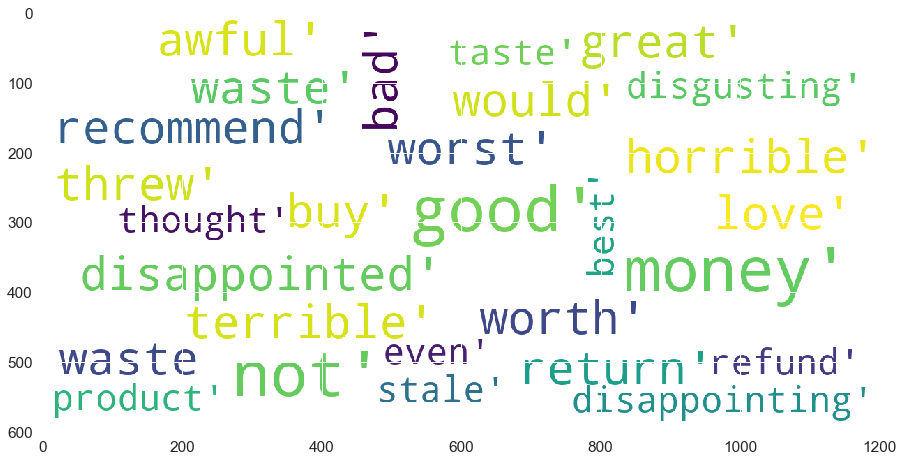

In [82]:
create_word_cloud(np.array(tfidf_features)[np.argsort(rf_optimal.feature_importances_)[::-1][:30]],30,(15,8))

## [5.3] Applying Random Forest on AVG W2V,<font color='red'> SET 3</font>

In [84]:
%time
# Unpickle AVG W2Vec Data
x_train = unpickle_data('avg_w2vec_train.pkl')
y_train = unpickle_data('y_train.pkl')
avg_w2vec_clf_rf = apply_random_forest(x_train, y_train, estimators_rf, max_depth_of_tree_rf, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 23.3min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 105.7min finished


In [100]:
# PPickling avg w2vec data
pickle_data('avg_w2vec_clf_rf.pkl', avg_w2vec_clf_rf)

In [86]:
print("Optimal Parameters: {}".format(avg_w2vec_clf_rf.best_params_))
print("Best AUC Score is: {}".format(avg_w2vec_clf_rf.best_score_))

Optimal Parameters: {'max_depth': 500, 'n_estimators': 120}
Best AUC Score is: 0.9002004875259134


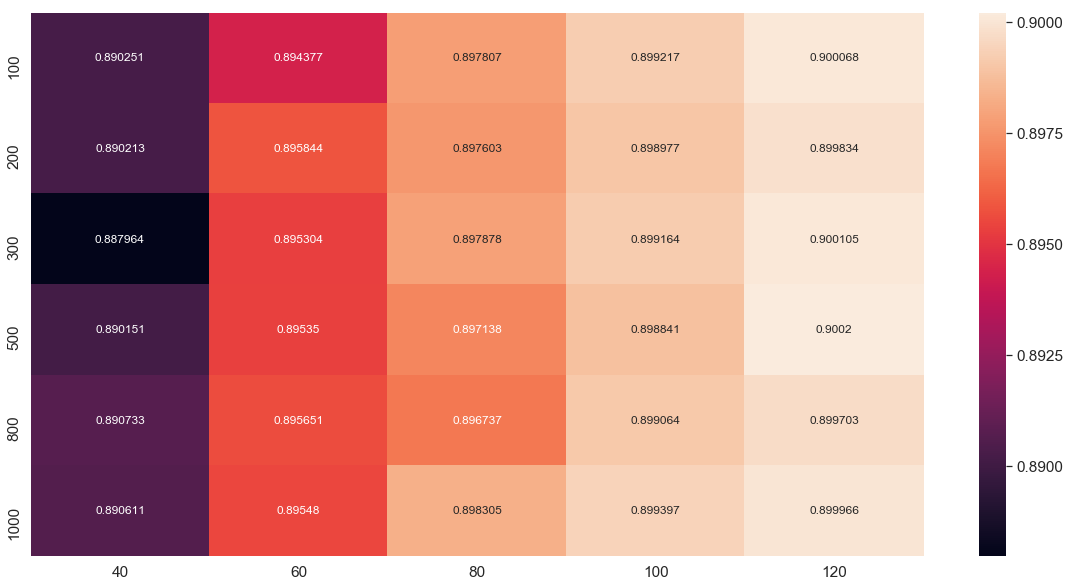

In [88]:
accuracy=avg_w2vec_clf_rf.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_rf),len(estimators_rf))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_rf, columns=estimators_rf)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

Accuracy on test set: 83.480%
Precision on test set: 0.835
Recall on test set: 0.999
F1-Score on test set: 0.910



Confusion Matrix of test set


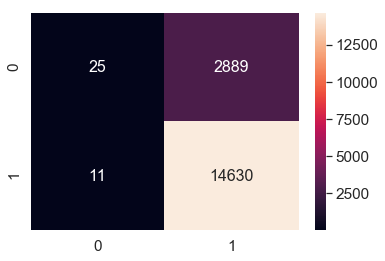

In [89]:
# Apply Random Forest on Test data
x_test = unpickle_data('avg_w2vec_test.pkl')
y_test = unpickle_data('y_test.pkl')
rf_optimal = RandomForestClassifier(max_depth=avg_w2vec_clf_rf.best_params_['max_depth'],n_estimators=avg_w2vec_clf_rf.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
proba = rf_optimal.predict_proba(x_test)
proba_train = rf_optimal.predict_proba(x_train)
pred = rf_optimal.predict(x_test)
pred_train = rf_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

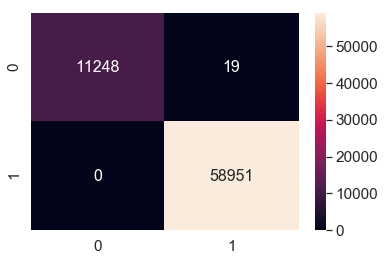

In [90]:
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

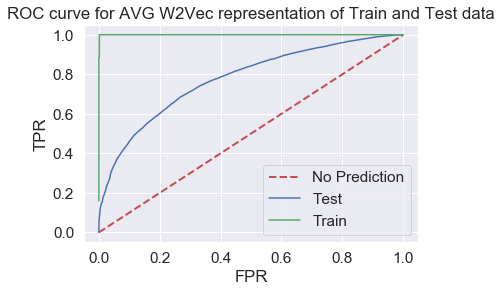

In [91]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr,fpr_train,tpr_train, 'ROC curve for AVG W2Vec representation of Train and Test data')

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [93]:
%time
# Unpickle TFIDF W2vec Data
x_train = unpickle_data('tfidf_w2vec_train.pkl')
y_train = unpickle_data('y_train.pkl')
tfidf_w2vec_clf_rf = apply_random_forest(x_train, y_train, estimators_rf, max_depth_of_tree_rf, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 23.0min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 81.9min finished


In [101]:
# PPickling avg w2vec data
pickle_data('tfidf_w2vec_clf_rf.pkl', tfidf_w2vec_clf_rf)

In [95]:
print("Optimal Parameters: {}".format(tfidf_w2vec_clf_rf.best_params_))
print("Best AUC Score is: {}".format(tfidf_w2vec_clf_rf.best_score_))

Optimal Parameters: {'max_depth': 1000, 'n_estimators': 120}
Best AUC Score is: 0.8752147666586584


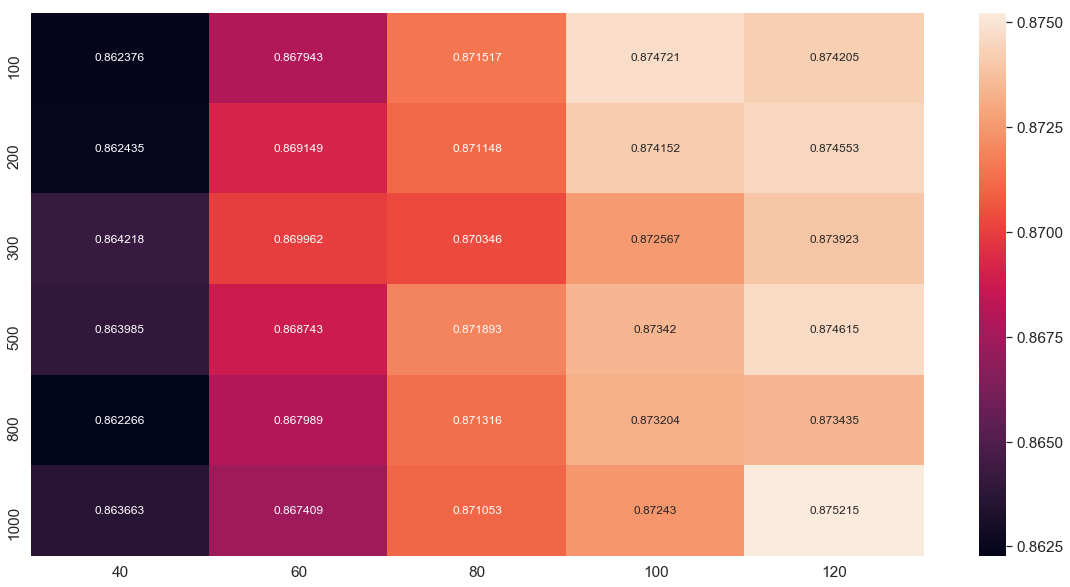

In [96]:
accuracy=tfidf_w2vec_clf_rf.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_rf),len(estimators_rf))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_rf, columns=estimators_rf)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

Accuracy on test set: 83.418%
Precision on test set: 0.835
Recall on test set: 0.999
F1-Score on test set: 0.909



Confusion Matrix of test set


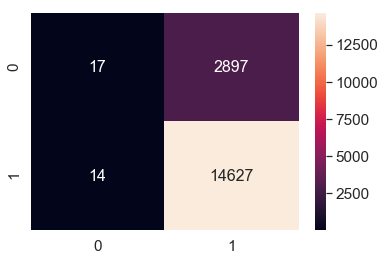

In [97]:
# Apply Random Forest on Test data
x_test = unpickle_data('tfidf_w2vec_test.pkl')
y_test = unpickle_data('y_test.pkl')
rf_optimal = RandomForestClassifier(max_depth=tfidf_w2vec_clf_rf.best_params_['max_depth'],n_estimators=tfidf_w2vec_clf_rf.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
proba = rf_optimal.predict_proba(x_test)
proba_train = rf_optimal.predict_proba(x_train)
pred = rf_optimal.predict(x_test)
pred_train = rf_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')



Confusion Matrix of train set


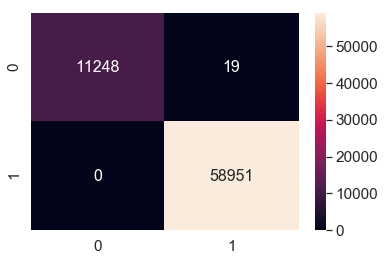

In [98]:
print("Confusion Matrix of train set")
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

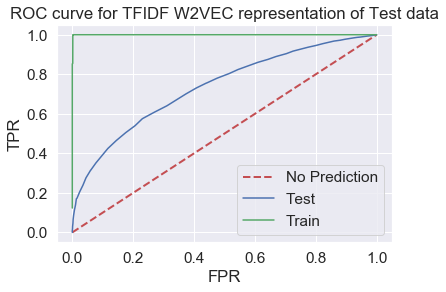

In [99]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr,fpr_train,tpr_train, 'ROC curve for TFIDF W2VEC representation of Test data')

# Feature Engineering on BOW (Random Forest)

In [102]:
%time
# Unpickle BoW Data
x_train = unpickle_data('bow_train.pkl')
y_train = unpickle_data('y_train.pkl')
x_train_f = unpickle_data('bow_train_f.pkl')
X_train = hstack([x_train, x_train_f])
bow_clf_rf_f = apply_random_forest(x_train, y_train, estimators_rf, max_depth_of_tree_rf, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 16.5min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 63.7min finished


In [103]:
# pickling the classifier object
pickle_data('bow_clf_rf_f.pkl',bow_clf_rf_f)

In [104]:
print("Optimal Parameters: {}".format(bow_clf_rf_f.best_params_))
print("Best AUC Score is: {}".format(bow_clf_rf_f.best_score_))

Optimal Parameters: {'max_depth': 800, 'n_estimators': 120}
Best AUC Score is: 0.9101934049969838


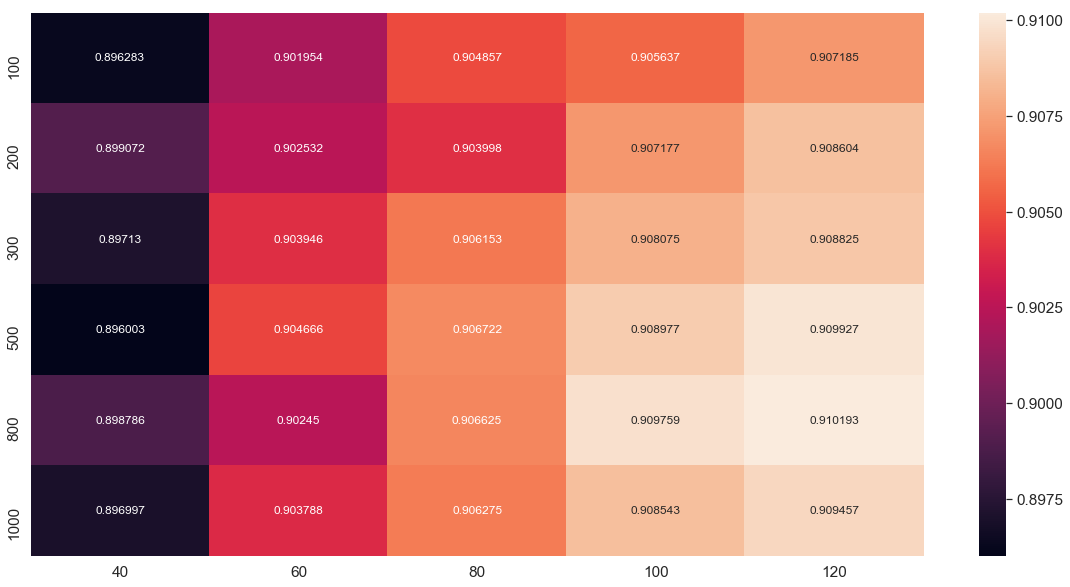

In [105]:
accuracy=bow_clf_rf_f.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_rf),len(estimators_rf))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_rf, columns=estimators_rf)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

Accuracy on test set: 87.781%
Precision on test set: 0.875
Recall on test set: 0.996
F1-Score on test set: 0.932



Confusion Matrix of test set


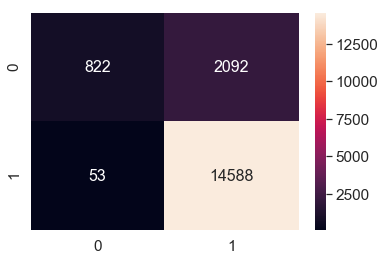

In [106]:
# Apply Random Forest on Test data
x_test = unpickle_data('bow_test.pkl')
y_test = unpickle_data('y_test.pkl')
x_test_f = unpickle_data('bow_test_f.pkl')
X_test = hstack([x_test, x_test_f])

rf_optimal = RandomForestClassifier(max_depth=bow_clf_rf_f.best_params_['max_depth'],n_estimators=bow_clf_rf_f.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
proba = rf_optimal.predict_proba(x_test)
proba_train = rf_optimal.predict_proba(x_train)
pred = rf_optimal.predict(x_test)
pred_train = rf_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion Matrix of test set


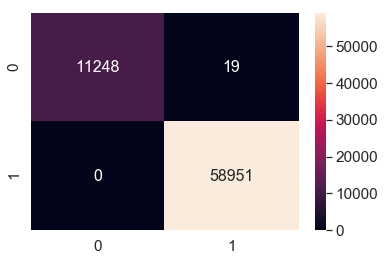

In [107]:
print("Confusion Matrix of test set")
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

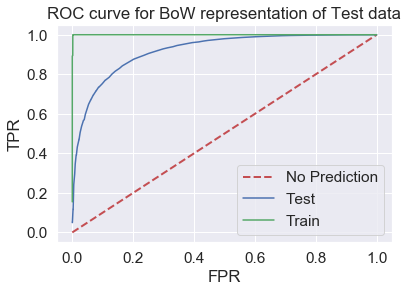

In [108]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr, fpr_train, tpr_train,'ROC curve for BoW representation of Test data')

# Feature Engineering on TFIDF (Random Forest)

In [110]:
%time
# Unpickle TFIDF Data
x_train = unpickle_data('tfidf_train.pkl')
y_train = unpickle_data('y_train.pkl')
x_train_f = unpickle_data('tfidf_train_f.pkl')
X_train = hstack([x_train, x_train_f])
tfidf_clf_rf_f = apply_random_forest(x_train, y_train, estimators_rf, max_depth_of_tree_rf, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 20.3min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 115.8min finished


In [111]:
# pickling the classifier object
pickle_data('tfidf_clf_rf_f.pkl',tfidf_clf_rf_f)

In [112]:
print("Optimal Parameters: {}".format(tfidf_clf_rf_f.best_params_))
print("Best AUC Score is: {}".format(tfidf_clf_rf_f.best_score_))

Optimal Parameters: {'max_depth': 800, 'n_estimators': 120}
Best AUC Score is: 0.9331505349203054


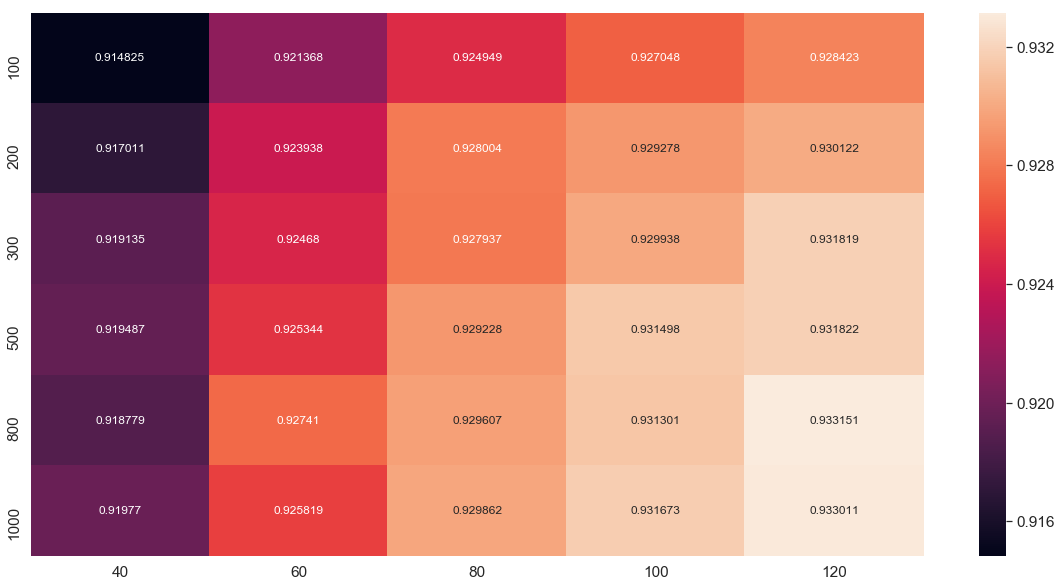

In [113]:
accuracy=tfidf_clf_rf_f.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_rf),len(estimators_rf))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_rf, columns=estimators_rf)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

Accuracy on test set: 87.633%
Precision on test set: 0.872
Recall on test set: 0.998
F1-Score on test set: 0.931



Confusion Matrix of test set


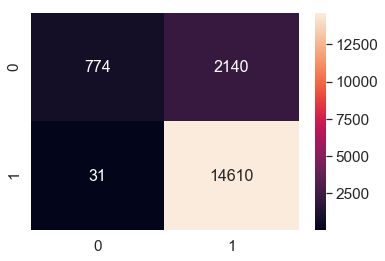

In [114]:
# Apply Random Forest on Test data
x_test = unpickle_data('tfidf_test.pkl')
y_test = unpickle_data('y_test.pkl')
x_test_f = unpickle_data('tfidf_test_f.pkl')
X_test = hstack([x_test, x_test_f])

rf_optimal = RandomForestClassifier(max_depth=tfidf_clf_rf_f.best_params_['max_depth'],n_estimators=tfidf_clf_rf_f.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
proba = rf_optimal.predict_proba(x_test)
proba_train = rf_optimal.predict_proba(x_train)
pred = rf_optimal.predict(x_test)
pred_train = rf_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion Matrix of train set


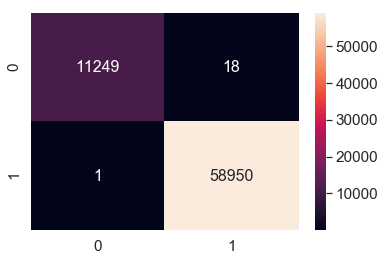

In [115]:
print("Confusion Matrix of train set")
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

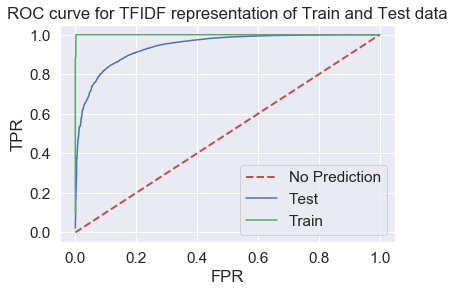

In [116]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr,fpr_train, tpr_train, 'ROC curve for TFIDF representation of Train and Test data')

# Applying GBDT

## [6.1] Applying XGBoost on BOW,<font color='red'> SET 1</font>

In [119]:
%time
# Unpickle BoW Data
x_train = unpickle_data('bow_train.pkl')
y_train = unpickle_data('y_train.pkl')
bow_clf_xgb = apply_xgboost(x_train, y_train, estimators_xgb, max_depth_of_tree_xgb, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  7.8min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 76.5min finished


In [120]:
# pickling the classifier object
pickle_data('bow_clf_xgb.pkl',bow_clf_xgb)

In [121]:
print("Optimal Parameters: {}".format(bow_clf_xgb.best_params_))
print("Best AUC Score is: {}".format(bow_clf_xgb.best_score_))

Optimal Parameters: {'max_depth': 11, 'n_estimators': 600}
Best AUC Score is: 0.9406394849211963


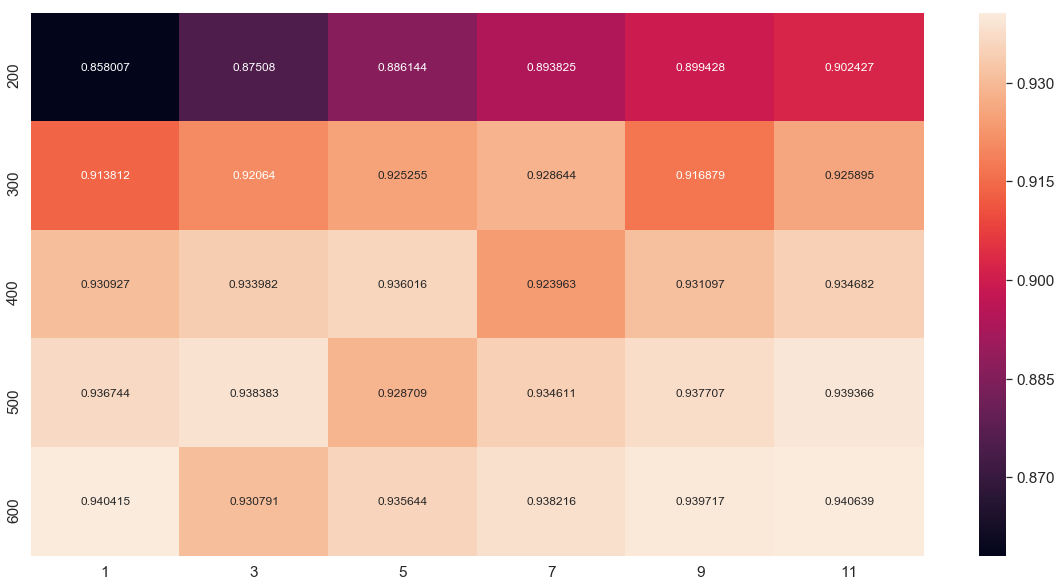

In [122]:
accuracy=bow_clf_xgb.cv_results_['mean_test_score'].reshape(len(estimators_xgb),len(max_depth_of_tree_xgb))
df=pd.DataFrame(accuracy, index=estimators_xgb, columns=max_depth_of_tree_xgb)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

Accuracy on test set: 91.575%
Precision on test set: 0.923
Recall on test set: 0.981
F1-Score on test set: 0.951



Confusion Matrix of test set


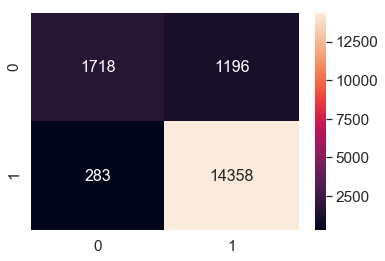

In [123]:
# Apply XGBoost on Test data
x_test = unpickle_data('bow_test.pkl')
y_test = unpickle_data('y_test.pkl')
xgb_optimal = XGBClassifier(max_depth=bow_clf_xgb.best_params_['max_depth'],n_estimators=bow_clf_xgb.best_params_['n_estimators'])
xgb_optimal.fit(x_train, y_train)
proba = xgb_optimal.predict_proba(x_test)
proba_train = xgb_optimal.predict_proba(x_train)
pred = xgb_optimal.predict(x_test)
pred_train = xgb_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion Matrix of train set


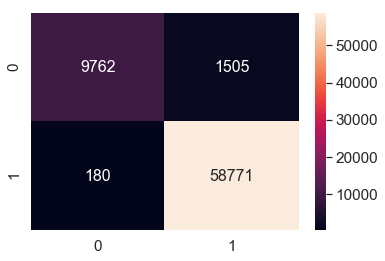

In [124]:
print("Confusion Matrix of train set")
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

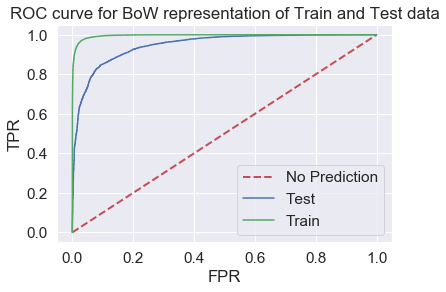

In [125]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr, fpr_train, tpr_train, 'ROC curve for BoW representation of Train and Test data')

### [6.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [126]:
# get the BoW feature names
bow_features=unpickle_data('bow_vectorizer.pkl').get_feature_names()

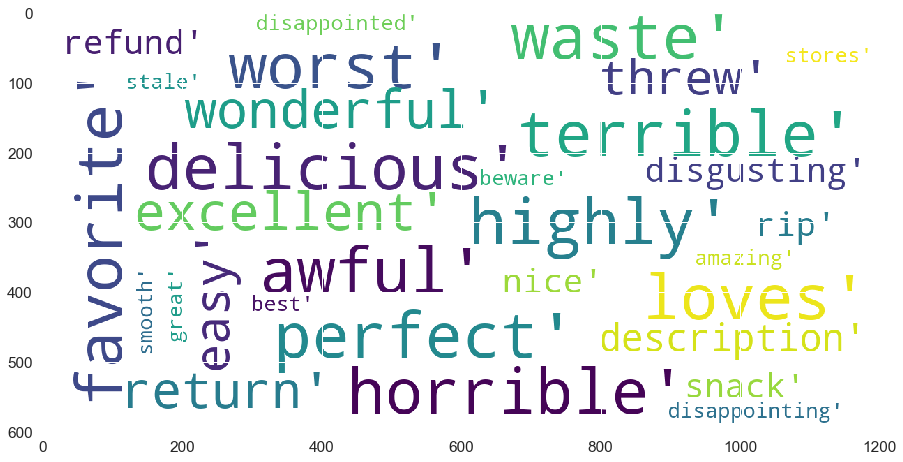

In [127]:
create_word_cloud(np.array(bow_features)[np.argsort(xgb_optimal.feature_importances_)[::-1][:30]],30,(15,8))

## [6.2] Applying XGBoost on TFIDF,<font color='red'> SET 2</font>

In [128]:
%time
# Unpickle TFIDF Data
x_train = unpickle_data('tfidf_train.pkl')
y_train = unpickle_data('y_train.pkl')
tfidf_clf_xgb = apply_xgboost(x_train, y_train, estimators_xgb, max_depth_of_tree_xgb, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 27.8min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 313.7min finished


In [129]:
# Pickling the tfidf classifier
pickle_data('tfidf_clf_xgb.pkl', tfidf_clf_xgb)

In [130]:
print("Optimal Parameters: {}".format(tfidf_clf_xgb.best_params_))
print("Best AUC Score is: {}".format(tfidf_clf_xgb.best_score_))

Optimal Parameters: {'max_depth': 11, 'n_estimators': 600}
Best AUC Score is: 0.951142934228121


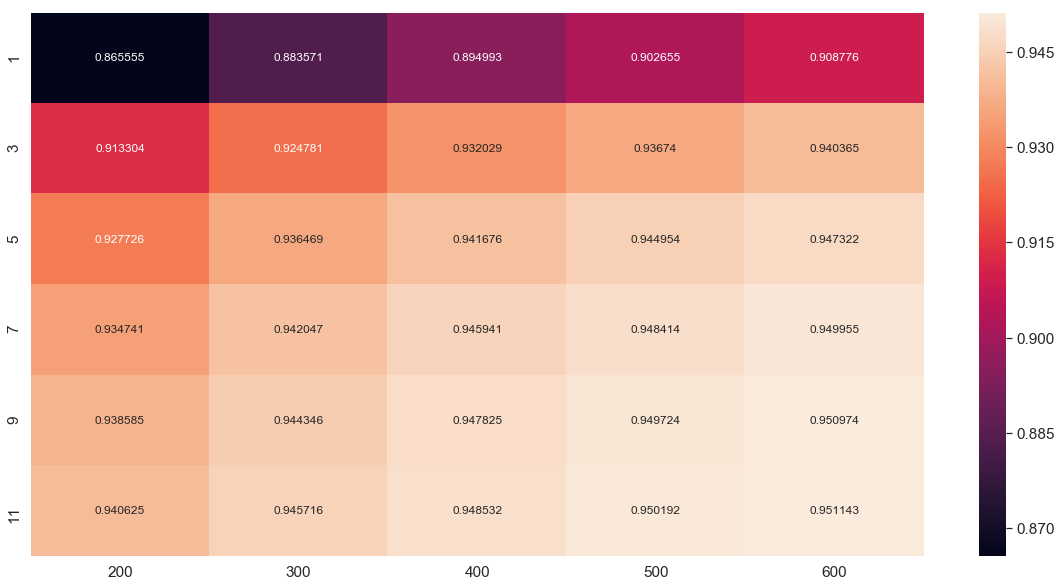

In [131]:
accuracy=tfidf_clf_xgb.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_xgb),len(estimators_xgb))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_xgb, columns=estimators_xgb)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

Accuracy on test set: 92.395%
Precision on test set: 0.931
Recall on test set: 0.981
F1-Score on test set: 0.956



Confusion Matrix of test set


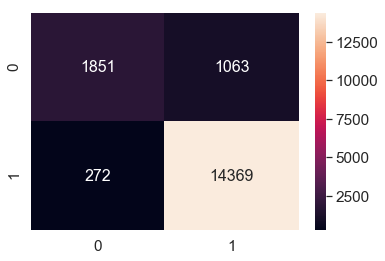

In [132]:
# Apply XGBoost on Test data
x_test = unpickle_data('tfidf_test.pkl')
y_test = unpickle_data('y_test.pkl')
xgb_optimal = XGBClassifier(max_depth=tfidf_clf_xgb.best_params_['max_depth'],n_estimators=tfidf_clf_xgb.best_params_['n_estimators'])
xgb_optimal.fit(x_train, y_train)
proba = xgb_optimal.predict_proba(x_test)
proba_train = xgb_optimal.predict_proba(x_train)
pred = xgb_optimal.predict(x_test)
pred_train = xgb_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion Matrix of train set


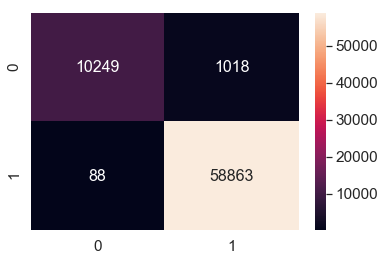

In [133]:
print("Confusion Matrix of train set")
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

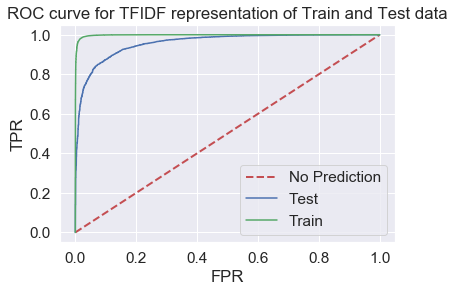

In [134]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr,fpr_train,tpr_train, 'ROC curve for TFIDF representation of Train and Test data')

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [135]:
# get the TFIDF feature names
tfidf_features=unpickle_data('tfidf_vectorizer.pkl').get_feature_names()

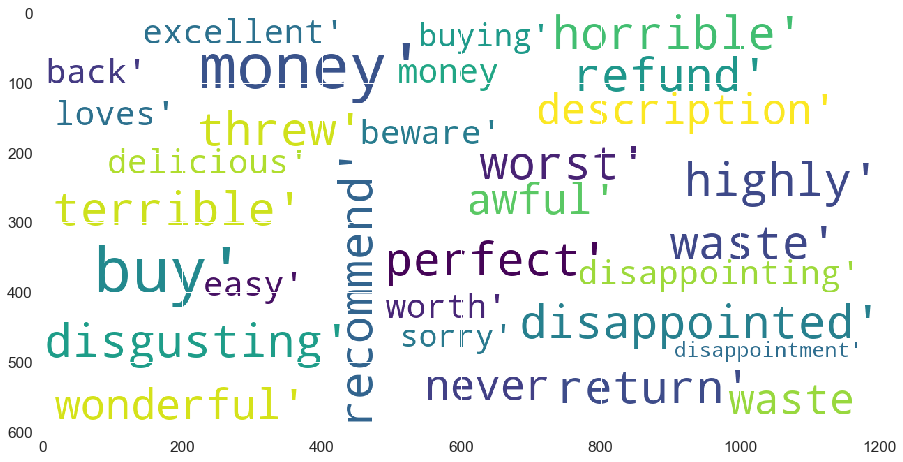

In [136]:
create_word_cloud(np.array(tfidf_features)[np.argsort(xgb_optimal.feature_importances_)[::-1][:30]],30,(15,8))

## [6.3] Applying XGBoost on AVG W2V,<font color='red'> SET 3</font>

In [10]:
# Unpickle AVG W2Vec Data
x_train = np.array(unpickle_data('avg_w2vec_train.pkl'))[:20000]
y_train = unpickle_data('y_train.pkl')[:20000]

In [15]:
%time
avg_w2vec_clf_xgb = apply_xgboost1(x_train, y_train, estimators_xgb1, max_depth_of_tree_xgb1, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 12.4min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 105.6min finished


In [17]:
# PPickling avg w2vec data
pickle_data('avg_w2vec_clf_xgb.pkl', avg_w2vec_clf_xgb)

In [18]:
print("Optimal Parameters: {}".format(avg_w2vec_clf_xgb.best_params_))
print("Best AUC Score is: {}".format(avg_w2vec_clf_xgb.best_score_))

Optimal Parameters: {'max_depth': 7, 'n_estimators': 500}
Best AUC Score is: 0.9111693460919223


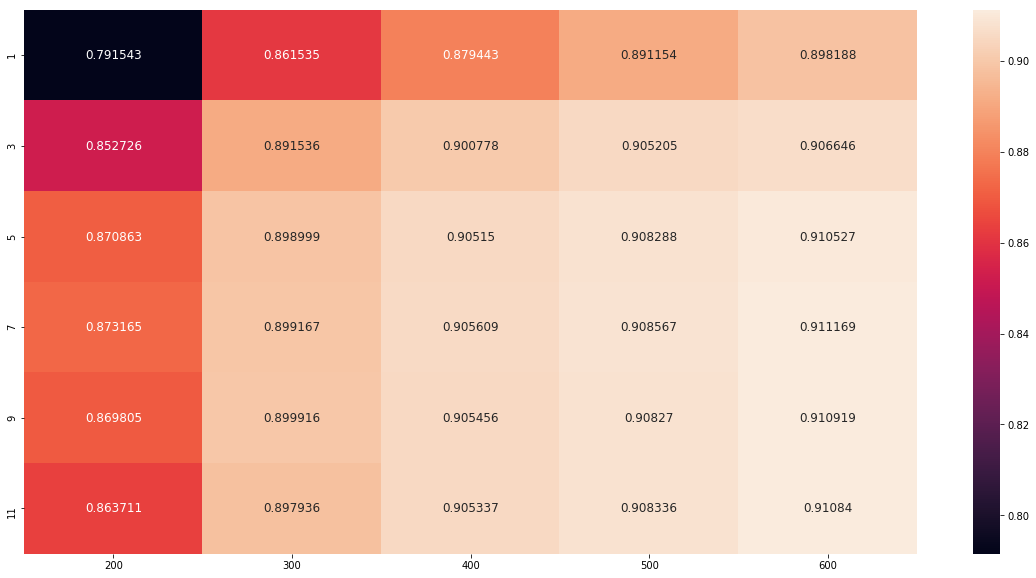

In [19]:
accuracy=avg_w2vec_clf_xgb.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_xgb),len(estimators_xgb))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_xgb, columns=estimators_xgb)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

C:\Users\soura\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\soura\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy on test set: 83.438%
Precision on test set: 0.834
Recall on test set: 1.000
F1-Score on test set: 0.910



Confusion Matrix of test set


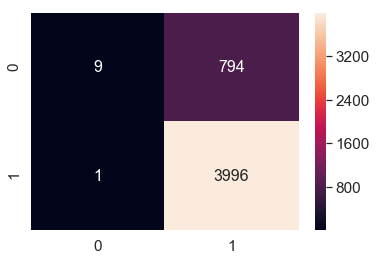

In [23]:
# Apply XGBoost on Test data
x_test = np.array(unpickle_data('avg_w2vec_test.pkl'))[:4800]
y_test = unpickle_data('y_test.pkl')[:4800]
xgb_optimal = XGBClassifier(colsample_bytree=0.5, max_depth=avg_w2vec_clf_xgb.best_params_['max_depth'],n_estimators=avg_w2vec_clf_xgb.best_params_['n_estimators'])
xgb_optimal.fit(x_train, y_train)
proba = xgb_optimal.predict_proba(x_test)
proba_train = xgb_optimal.predict_proba(x_train)
pred = xgb_optimal.predict(x_test)
pred_train = xgb_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

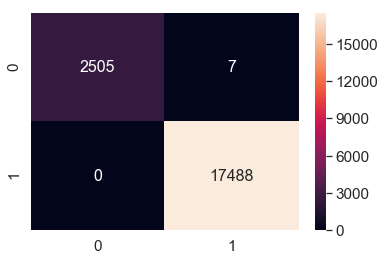

In [22]:
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

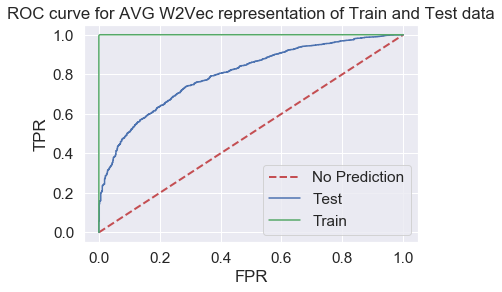

In [24]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr,fpr_train,tpr_train, 'ROC curve for AVG W2Vec representation of Train and Test data')

## [6.4] Applying XGBoost on TFIDF W2V,<font color='red'> SET 4</font>

In [25]:
%time
# Unpickle TFIDF Data
x_train = np.array(unpickle_data('tfidf_w2vec_train.pkl'))[:20000]
y_train = unpickle_data('y_train.pkl')[:20000]
tfidf_w2vec_clf_xgb = apply_xgboost1(x_train, y_train, estimators_xgb1, max_depth_of_tree_xgb1, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 77.5min finished


In [27]:
# PPickling avg w2vec data
pickle_data('tfidf_w2vec_clf_xgb.pkl', tfidf_w2vec_clf_xgb)

In [13]:
print("Optimal Parameters: {}".format(tfidf_w2vec_clf_xgb.best_params_))
print("Best AUC Score is: {}".format(tfidf_w2vec_clf_xgb.best_score_))

Optimal Parameters: {'max_depth': 9, 'n_estimators': 500}
Best AUC Score is: 0.8872612129373323


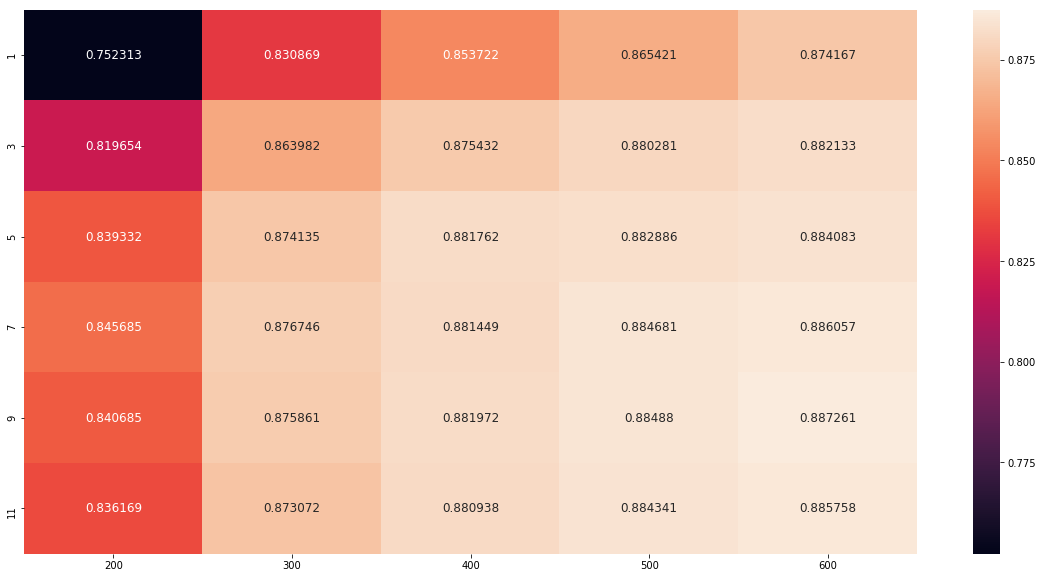

In [14]:
accuracy=tfidf_w2vec_clf_xgb.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_xgb),len(estimators_xgb))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_xgb, columns=estimators_xgb)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

In [16]:
x_test = np.array(unpickle_data('tfidf_w2vec_test.pkl'))
x_test.shape

(17555, 500)

C:\Users\soura\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\soura\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy on test set: 83.919%
Precision on test set: 0.840
Recall on test set: 0.998
F1-Score on test set: 0.912



Confusion Matrix of test set


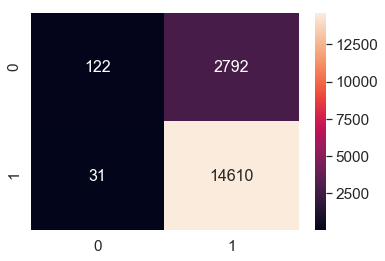

In [17]:
# Apply XGBoost on Test data
x_test = np.array(unpickle_data('tfidf_w2vec_test.pkl'))
y_test = unpickle_data('y_test.pkl')
xgb_optimal = XGBClassifier(max_depth=tfidf_w2vec_clf_xgb.best_params_['max_depth'],n_estimators=tfidf_w2vec_clf_xgb.best_params_['n_estimators'])
xgb_optimal.fit(x_train, y_train)
proba = xgb_optimal.predict_proba(x_test)
proba_train = xgb_optimal.predict_proba(x_train)
pred = xgb_optimal.predict(x_test)
pred_train = xgb_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')



Confusion Matrix of train set


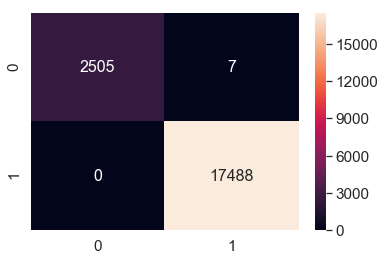

In [18]:
print("Confusion Matrix of train set")
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

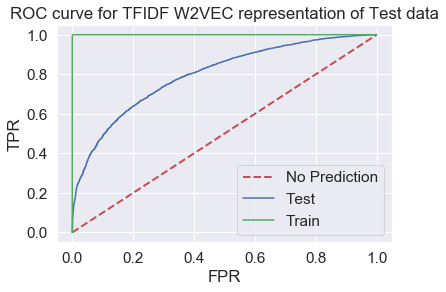

In [19]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr,fpr_train,tpr_train, 'ROC curve for TFIDF W2VEC representation of Test data')

# Feature Engineering on BOW (XGBoost)

In [20]:
%time
# Unpickle BoW Data
x_train = unpickle_data('bow_train.pkl')
y_train = unpickle_data('y_train.pkl')
x_train_f = unpickle_data('bow_train_f.pkl')
X_train = hstack([x_train, x_train_f])
bow_clf_xgb_f = apply_xgboost(x_train, y_train, estimators_xgb, max_depth_of_tree_xgb, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 14.5min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 96.3min finished


In [21]:
# pickling the classifier object
pickle_data('bow_clf_xgb_f.pkl',bow_clf_xgb_f)

In [22]:
print("Optimal Parameters: {}".format(bow_clf_xgb_f.best_params_))
print("Best AUC Score is: {}".format(bow_clf_xgb_f.best_score_))

Optimal Parameters: {'max_depth': 11, 'n_estimators': 600}
Best AUC Score is: 0.9406394849211963


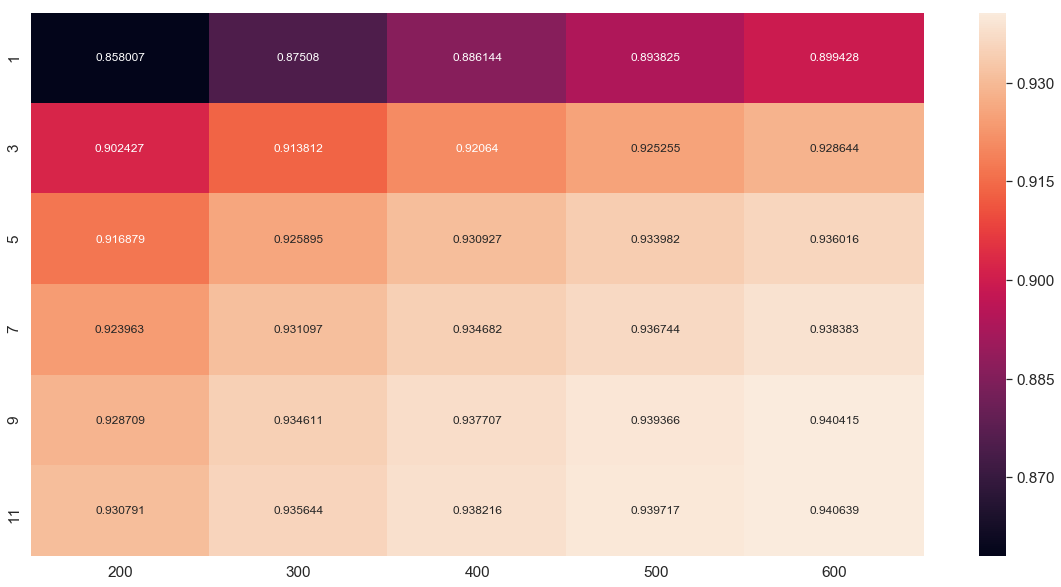

In [23]:
accuracy=bow_clf_xgb_f.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_xgb),len(estimators_xgb))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_xgb, columns=estimators_xgb)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

C:\Users\soura\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\soura\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy on test set: 91.575%
Precision on test set: 0.923
Recall on test set: 0.981
F1-Score on test set: 0.951



Confusion Matrix of test set


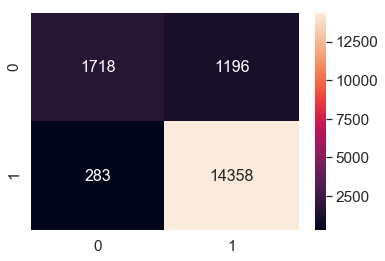

In [24]:
# Apply XGBoost on Test data
x_test = unpickle_data('bow_test.pkl')
y_test = unpickle_data('y_test.pkl')
x_test_f = unpickle_data('bow_test_f.pkl')
X_test = hstack([x_test, x_test_f])

xgb_optimal = XGBClassifier(max_depth=bow_clf_xgb_f.best_params_['max_depth'],n_estimators=bow_clf_xgb_f.best_params_['n_estimators'])
xgb_optimal.fit(x_train, y_train)
proba = xgb_optimal.predict_proba(x_test)
proba_train = xgb_optimal.predict_proba(x_train)
pred = xgb_optimal.predict(x_test)
pred_train = xgb_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion Matrix of test set


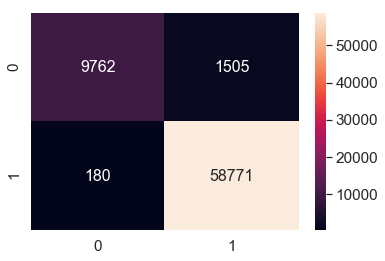

In [25]:
print("Confusion Matrix of test set")
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

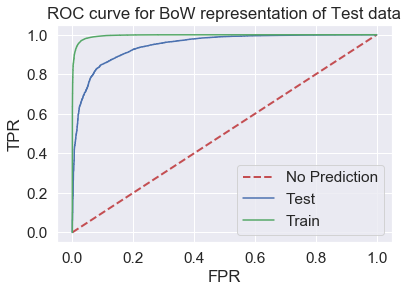

In [26]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr, fpr_train, tpr_train,'ROC curve for BoW representation of Test data')

# Feature Engineering on TFIDF (XGBoost)

In [27]:
%time
# Unpickle BoW Data
x_train = unpickle_data('tfidf_train.pkl')
y_train = unpickle_data('y_train.pkl')
x_train_f = unpickle_data('tfidf_train_f.pkl')
X_train = hstack([x_train, x_train_f])
tfidf_clf_xgb_f = apply_xgboost(x_train, y_train, estimators_xgb, max_depth_of_tree_xgb, 5)

Wall time: 0 ns
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 27.8min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 303.9min finished


In [29]:
# pickling the classifier object
pickle_data('tfidf_clf_xgb_f.pkl',tfidf_clf_xgb_f)

In [30]:
print("Optimal Parameters: {}".format(tfidf_clf_xgb_f.best_params_))
print("Best AUC Score is: {}".format(tfidf_clf_xgb_f.best_score_))

Optimal Parameters: {'max_depth': 11, 'n_estimators': 600}
Best AUC Score is: 0.951142934228121


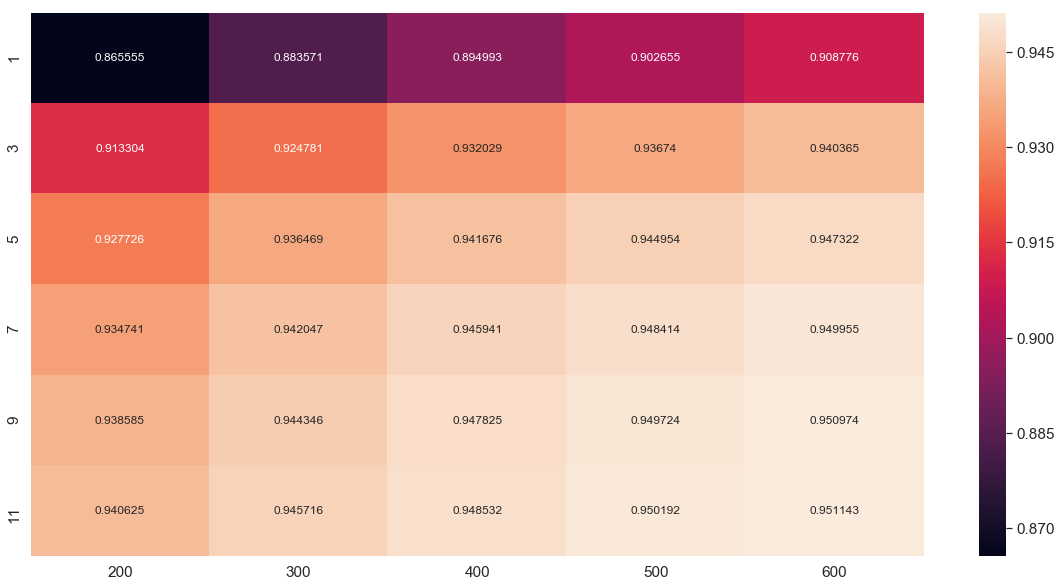

In [31]:
accuracy=tfidf_clf_xgb_f.cv_results_['mean_test_score'].reshape(len(max_depth_of_tree_xgb),len(estimators_xgb))
df=pd.DataFrame(accuracy, index=max_depth_of_tree_xgb, columns=estimators_xgb)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df, annot=True,annot_kws={"size": 12}, fmt='g')

C:\Users\soura\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\soura\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy on test set: 92.395%
Precision on test set: 0.931
Recall on test set: 0.981
F1-Score on test set: 0.956



Confusion Matrix of test set


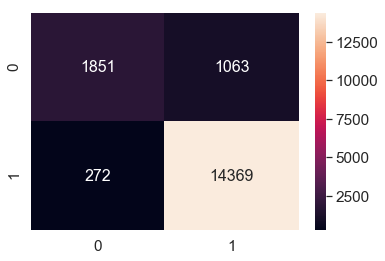

In [32]:
# Apply XGBoost on Test data
x_test = unpickle_data('tfidf_test.pkl')
y_test = unpickle_data('y_test.pkl')
x_test_f = unpickle_data('tfidf_test_f.pkl')
X_test = hstack([x_test, x_test_f])

xgb_optimal = XGBClassifier(max_depth=tfidf_clf_xgb_f.best_params_['max_depth'],n_estimators=tfidf_clf_xgb_f.best_params_['n_estimators'])
xgb_optimal.fit(x_train, y_train)
proba = xgb_optimal.predict_proba(x_test)
proba_train = xgb_optimal.predict_proba(x_train)
pred = xgb_optimal.predict(x_test)
pred_train = xgb_optimal.predict(x_train)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion Matrix of train set


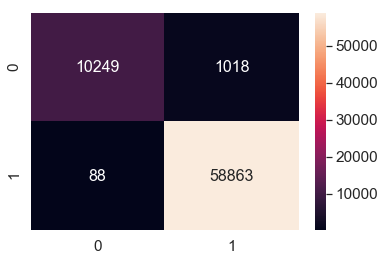

In [33]:
print("Confusion Matrix of train set")
df_cm_train = pd.DataFrame(confusion_matrix(y_train, pred_train), range(2),range(2))
sns.heatmap(df_cm_train, annot=True,annot_kws={"size": 16}, fmt='g')

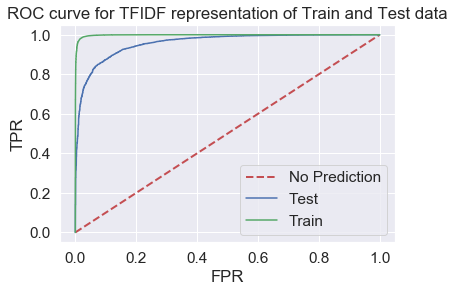

In [34]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, proba_train[:, 1])
plot_roc_curve_for_test(fpr, tpr,fpr_train, tpr_train, 'ROC curve for TFIDF representation of Train and Test data')

# [6] Conclusions

In [1]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Vectorizer", "Max Depth", "Base Learners", "AUC","Accuracy", "Precision", "Recall", "F1 Score", "Feature Engineering"]

x.add_row(["Random Forest","Bow", 1000, 120, 0.910,87.707, 0.874, 0.996, 0.931, "No"])
x.add_row(["Random Forest","TFIDF", 800, 120, 0.933,87.479, 0.871, 0.998, 0.930, "No"])
x.add_row(["Random Forest","AVG W2Vec", 500, 120, 0.900,83.403, 0.835, 0.999, 0.910, "No"])
x.add_row(["Random Forest","TFIDF W2Vec", 1000, 120, 0.875,83.418, 0.835, 0.999, 0.909, "No"])
x.add_row(["Random Forest","Bow", 800, 120, 0.910,87.781, 0.875, 0.996, 0.932, "YES"])
x.add_row(["Random Forest","TFIDF", 800, 120, 0.933,87.633, 0.872, 0.998, 0.931, "YES"])


x.add_row(["XGBoost","Bow", 11, 600, 0.940,91.575, 0.923, 0.981, 0.951, "No"])
x.add_row(["XGBoost","TFIDF", 11, 600, 0.951,92.395, 0.931, 0.981, 0.956, "No"])
x.add_row(["XGBoost","AVG W2Vec", 9, 500, 0.887,83.919, 0.840, 998, 0.912, "No"])
x.add_row(["XGBoost","TFIDF W2Vec", 11, 500, 0.817,83.133, 0.843, 0.980, 0.906, "No"])
x.add_row(["XGBoost","Bow", 11, 600, 0.940,91.575, 0.923, 0.981, 0.951, "YES"])
x.add_row(["XGBoost","TFIDF", 11, 600, 0.951,92.395, 0.931, 0.981, 0.956, "YES"])
print(x)

+---------------+-------------+-----------+---------------+-------+----------+-----------+--------+----------+---------------------+
|     Model     |  Vectorizer | Max Depth | Base Learners |  AUC  | Accuracy | Precision | Recall | F1 Score | Feature Engineering |
+---------------+-------------+-----------+---------------+-------+----------+-----------+--------+----------+---------------------+
| Random Forest |     Bow     |    1000   |      120      |  0.91 |  87.707  |   0.874   | 0.996  |  0.931   |          No         |
| Random Forest |    TFIDF    |    800    |      120      | 0.933 |  87.479  |   0.871   | 0.998  |   0.93   |          No         |
| Random Forest |  AVG W2Vec  |    500    |      120      |  0.9  |  83.403  |   0.835   | 0.999  |   0.91   |          No         |
| Random Forest | TFIDF W2Vec |    1000   |      120      | 0.875 |  83.418  |   0.835   | 0.999  |  0.909   |          No         |
| Random Forest |     Bow     |    800    |      120      |  0.91 |  

### We can clearly see the Bagging (Random Forest) and Boosting (XGBoost) are computationally expensive with respect to time.
### For this particular scenario Random Forest is not that efficient like XGBoost, although the training efficiency is far better than test data, so we can say that it is prone to overfitting.
### XGBoost performs brilliantly well in this dataset giving a very high accuracy in all of the vectorizers.
### TFIDF vectorizer is the best in this case in accordance with XGBoost giving high AUC (95%) and high Accuracy (92%)